# Exercise 04 - Due Saturday, November 18 at 12pm

*Objectives*: Gain experience loading a CSV dataset into a star schema. Explore the data by writing and executing a number of SQL queries using common syntax and functions and describing your findings.

*Grading criteria*: The tasks should all be completed, and questions should all be answered with SQL queries in the space provided, unless a text answer is requested. Results should be correct, according to the embedded tests. The notebook itself should be completely reproducible; from start to finish, another person should be able to use the same code to obtain the same results as yours.  Note that you will receive no more than partial credit if you do not add text/markdown cells explaining your thinking at each major step in each problem.

** Add your markdown and code cells only in the designated areas after "Answers:". Do not remove or change any existing cells. **

*Deadline*: Saturday, November 18, 12pm.

## Setup - obtain data

The US City Open Data Census has data on [Campaign Finance Contributions](http://us-city.census.okfn.org/dataset/campaign-finance).  Let's take a look at data from [Washington DC](http://opendata.dc.gov/datasets/campaign-financial-contributions).

First we download the dataset:

In [1]:
!wget -O dc_contributions.csv https://opendata.arcgis.com/datasets/6443e0b5b2454e86a3208b8a38fdee84_34.csv

--2017-11-17 16:27:11--  https://opendata.arcgis.com/datasets/6443e0b5b2454e86a3208b8a38fdee84_34.csv
Resolving opendata.arcgis.com (opendata.arcgis.com)... 52.22.192.109, 34.235.70.5
Connecting to opendata.arcgis.com (opendata.arcgis.com)|52.22.192.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘dc_contributions.csv’

dc_contributions.cs     [   <=>              ]  53.31M   109MB/s    in 0.5s    

2017-11-17 16:27:12 (109 MB/s) - ‘dc_contributions.csv’ saved [55903436]



## Part 1 - examine the data (30 points)

**Question 1** :
Use `csvstat` and other tools as you see fit and observe its contents. Describe what you see:  How many records does  this dataset have? What do all the columns mean?  Are there null values?  Which columns interest you the most? Which columns present facts and which columns present dimensions?

Insert a combination of code and text/markdown cells here to review the data and describe what you find.

Hint: to get help on command line tools, try the `--help` option. For example: `csvstat --help`.

Hint: due to the size of the dataset, if you use `csvstat`, you can apply it on sample or the first 10000 lines.

**Answer:**

In [2]:
!wc -l dc_contributions.csv

214982 dc_contributions.csv


The result indicates there are 214982 records in the dataset

In [3]:
!csvcut -n dc_contributions.csv

  1: ﻿OBJECTID
  2: COMMITTEENAME
  3: CANDIDATENAME
  4: ELECTIONYEAR
  5: CONTRIBUTORNAME
  6: ADDRESS
  7: CONTRIBUTORTYPE
  8: CONTRIBUTIONTYPE
  9: EMPLOYER
 10: EMPLOYERADDRESS
 11: AMOUNT
 12: DATEOFRECEIPT
 13: ADDRESS_ID
 14: XCOORD
 15: YCOORD
 16: LATITUDE
 17: LONGITUDE
 18: FULLADDRESS
 19: GIS_LAST_MOD_DTTM


1. The ID of observation.
2. The names of committees.
3. The names of candidates in election.
4. The year when candidates participate in the election.
5. The names of contributors.
6. The address of contributors.
7. The types of contributors.
8. The types of contributions.
9. The employers of contributors.
10. The address of employers of contributors.
11. The amount of contribution.
12. The date of receipt of contribution.
13. ID of address.
14. X coordination.
15. Y coordination.
16. Latitude of address of employer.
17. Longitude of address of employer.
18. Full address of contributors.
19. The date and time of last modification in GIS.

In [4]:
!head -n 10000 dc_contributions.csv | csvstat

  1. ﻿OBJECTID
	<class 'int'>
	Nulls: False
	Min: 1001
	Max: 10999
	Sum: 59994000
	Mean: 6000.0
	Median: 6000
	Standard Deviation: 2886.4626563783336
	Unique values: 9999
  2. COMMITTEENAME
	<class 'str'>
	Nulls: False
	Unique values: 329
	5 most frequent values:
		Fenty 2010:	1101
		Re-Elect Jim Graham  (2006):	438
		Re-Elect Kwame R. Brown:	390
		Washington DC Association of Realtors PAC:	356
		Muriel Bowser for Mayor:	351
	Max length: 82
  3. CANDIDATENAME
	<class 'str'>
	Nulls: True
	Unique values: 171
	5 most frequent values:
		Adrian Fenty:	1149
		Muriel Bowser:	789
		Kwame Brown:	646
		Jim Graham:	450
		Vincent Gray:	361
	Max length: 24
  4. ELECTIONYEAR
	<class 'int'>
	Nulls: False
	Min: 2002
	Max: 2018
	Sum: 20093811
	Mean: 2009.5820582058207
	Median: 2010
	Standard Deviation: 4.314684666877673
	Unique values: 13
	5 most frequent values:
		2010:	1670
		2014:	1488
		2006:	1410
		2002:	1075
		2012:	1017
  5. CONTRIBUTORNAME
	<class 'str'>
	Nulls: True
	Unique values: 8168
	5 mos

There are null values in Candidatename, Contributorname, Address, Contributortype, Contributiontype, Employer, Employeraddress, Amount, Address_ID, Xcoord, Ycoord, Latitude, Longitude, Fulladdress.

I am interested in names of candidates because it can tell me which candidate is more likely to get support.

Dimensions:
OBJECTID, COMMITTEENAME, CANDIDATENAME, ELECTIONYEAR, CONTRIBUTORNAME, ADDRESS, CONTRIBUTORTYPE, CONTRIBUTIONTYPE, EMPLOYER, EMPLOYERADDRESS, DATEOFRECEIPT, ADDRESS_ID, XCOORD, YCOORD, LATITUDE, LONGITUDE, FULLADDRESS, GIS_LAST_MOD_DTTM

Facts:
AMOUNT

## Part 2 - create a database and load the data (40 points)
Create and connect to a new database, create database tables in it based on the following provided star schema, and load this dataset into it. 

* `campaign` (`campaign_key`, `committee_name`, `candidate_name`, `election_year`)
* `contributor` (`contributor_key`, `name`, `type`, `employer`)
* `contribution_facts` (`campaign_key`, `contributor_key`, `amount`)

In [1]:
%load_ext sql

In [2]:
!dropdb --if-exists -U student assignment4

In [3]:
!createdb -U student assignment4

In [2]:
%sql postgresql://student@/assignment4

'Connected: student@assignment4'

First, let's create the table `contribution_facts`:

In [5]:
%%sql
DROP TABLE IF EXISTS contribution_facts;

CREATE TABLE contribution_facts (
    id INTEGER,
    committee_name VARCHAR(500),
    candidate_name VARCHAR(50),
    election_year INTEGER,
    contributor_name VARCHAR(500),
    contributor_address VARCHAR(500),
    contributor_type VARCHAR(100),
    contribution_type VARCHAR(100),
    employer VARCHAR(500),
    employer_address VARCHAR(500),
    amount NUMERIC(20, 2),
    date_of_receipt DATE,
    address_id INTEGER,
    address_x NUMERIC(20, 2),
    address_y NUMERIC(20, 2),
    address_latitude NUMERIC,
    address_longitude NUMERIC,
    address_full VARCHAR(500),
    gis_last_mod TIMESTAMPTZ NOT NULL
)

Done.
Done.


[]

** Question 2 (10 points)** :
Load the dataset into the table `contribution_facts` and verify the loaded records.

Hint: If you get some errors, please examine the error messages carefully and fix the problems, including any problems in the above CREATE TABLE statement.

** Answer: **

In [6]:
%%sql
COPY contribution_facts FROM '/home/ubuntu/dc_contributions.csv'
CSV
HEADER;

214975 rows affected.


[]

I just use the copy function to load the data into database. And there are errors because there are null values in some columns which are defined with constraint of no null values. So I change the CREATE TABLE statement.

** End of answer to Question 2 **

Next, we are going to create the dimension table `contributor`. 

First let's work on the SELECT statement that extracts contributor-related dimension details like `contributor_name`, `contributor_type` and `employer`.

In [7]:
%%sql
SELECT DISTINCT contributor_name, contributor_type, employer
FROM contribution_facts
LIMIT 10;

10 rows affected.


contributor_name,contributor_type,employer
None,None,None
Victor Ayala,Individual,DC Taxicab Commission
Harry Harrison,Individual,Aronson LLC
DC Development & Consulting LLC,Corporation,None
Virginia Contractors Supply Inc,Corporation,None
Euclid Mortgage Aservices,Corporation,None
Kool Smiles,Corporation,None
Summer Smith,Individual,Not reported
Shelly Waite,Individual,Waite Secured Line Technology Solutions LLC
Clark Ray,Individual,DC Governmnet


Please note NULLs in the query result. Now we can create the dimension table `contributor` to house the dimensions `contributor_name`, `contributor_type` and `employer`.

In [8]:
%%sql
DROP TABLE IF EXISTS contributor;

CREATE TABLE contributor (
    contributor_key SERIAL PRIMARY KEY,
    name VARCHAR(500),
    type VARCHAR(100),
    employer VARCHAR(500)
);

Done.
Done.


[]

Populate the dimension table with unique values of these three dimensions from the dataset.

In [9]:
%%sql
INSERT INTO contributor (name, type, employer)
SELECT DISTINCT contributor_name, contributor_type, employer
FROM contribution_facts;

144249 rows affected.


[]

Next, we add a foreign key column to the fact table that references `contributor` dimension table.

In [10]:
%%sql
ALTER TABLE contribution_facts
ADD COLUMN contributor_key INTEGER,
ADD CONSTRAINT fk_contributor_key
    FOREIGN KEY (contributor_key)
    REFERENCES contributor (contributor_key);

Done.


[]

In [11]:
%%sql
SELECT contributor_key FROM contribution_facts
LIMIT 10;

10 rows affected.


contributor_key
None
None
None
None
None
None
None
None
None
None


As we can see, the values for the `contributor_key` are NULLs initially. We will populate `contributor_key` with correct values next.

First let's create an index on all columns in `contributor` to improve the performance of queries.

In [12]:
%%sql
DROP INDEX IF EXISTS idx_contributor;

CREATE INDEX idx_contributor ON contributor (name, type, employer);

Done.
Done.


[]

In [13]:
%%sql
UPDATE contribution_facts
SET contributor_key = contributor.contributor_key
FROM contributor
WHERE contribution_facts.contributor_name = contributor.name 
    AND contribution_facts.contributor_type = contributor.type 
    AND contribution_facts.employer = contributor.employer

123395 rows affected.


[]

** Question 3 (10 points) **:
Have all rows in `contribution_facts` been updated by the above UPDATE statement? If not, explain why some rows weren't updated. Modify the UPDATE statement to fix it.

** Answer: **

In [14]:
%%sql
SELECT DISTINCT contributor_key FROM contribution_facts
LIMIT 10;

10 rows affected.


contributor_key
None
2848
119488
2026
103294
46770
55290
59315
62012
103179


According to the result above, we can know that not all of rows have been updated. It is due to the null values in the data.

In [15]:
%%sql
UPDATE contribution_facts
SET contributor_key = contributor.contributor_key
FROM contributor
WHERE (case when contribution_facts.contributor_name IS NULL THEN 'missing' ELSE contribution_facts.contributor_name END) 
    = (case when contributor.name IS NULL THEN 'missing' ELSE contributor.name END) 
    AND (case when contribution_facts.contributor_type IS NULL THEN 'missing' ELSE contribution_facts.contributor_type END) 
    = (case when contributor.type IS NULL THEN 'missing' ELSE contributor.type END)
    AND (case when contribution_facts.employer IS NULL THEN 'missing' ELSE contribution_facts.employer END) 
    = (case when contributor.employer IS NULL THEN 'missing' ELSE contributor.employer END);

214975 rows affected.


[]

Because null values can not compared, I replace null values with text 'missing' which can be compared.

In [16]:
%%sql
SELECT DISTINCT contributor_key FROM contribution_facts
WHERE contributor_key is null
LIMIT 10;

0 rows affected.


contributor_key


** End of answer to Question 3 **

** Question 4 (20 points) **:
Now it is your turn to create and populate the dimension table `campaign`, add the campaign foreign key to the fact table and populate the foreign key values for all the facts.

** Answer: **

In [17]:
%%sql
DROP TABLE IF EXISTS campaign;

CREATE TABLE campaign (
    campaign_key SERIAL PRIMARY KEY,
    committee_name VARCHAR(500),
    candidate_name VARCHAR(50),
    election_year INTEGER
);

Done.
Done.


[]

In [18]:
%%sql
INSERT INTO campaign (committee_name, candidate_name, election_year)
SELECT DISTINCT committee_name, candidate_name, election_year
FROM contribution_facts;

1238 rows affected.


[]

In [19]:
%%sql
ALTER TABLE contribution_facts
ADD COLUMN campaign_key INTEGER,
ADD CONSTRAINT fk_campaignr_key
    FOREIGN KEY (campaign_key)
    REFERENCES campaign (campaign_key);

Done.


[]

In [20]:
%%sql
DROP INDEX IF EXISTS idx_campaign;

CREATE INDEX idx_campaign ON campaign (committee_name, candidate_name, election_year);

Done.
Done.


[]

In [21]:
%%sql
UPDATE contribution_facts
SET campaign_key = campaign.campaign_key
FROM campaign
WHERE (case when contribution_facts.committee_name IS NULL THEN 'missing' ELSE contribution_facts.committee_name END) 
    = (case when campaign.committee_name IS NULL THEN 'missing' ELSE campaign.committee_name END) 
    AND (case when contribution_facts.candidate_name IS NULL THEN 'missing' ELSE contribution_facts.candidate_name END) 
    = (case when campaign.candidate_name IS NULL THEN 'missing' ELSE campaign.candidate_name END)
    AND (case when contribution_facts.election_year IS NULL THEN 0 ELSE contribution_facts.election_year END) 
    = (case when campaign.election_year IS NULL THEN 0 ELSE campaign.election_year END);

214975 rows affected.


[]

In [22]:
%%sql
SELECT DISTINCT campaign_key FROM campaign
WHERE campaign_key is null
LIMIT 10;

0 rows affected.


campaign_key


As the process of creating table contributor, I also create table campaign.

** End of answer to Question 4 **

We can now remove all columns in `contribution_facts` that are not facts nor foreign keys of dimension tables.

In [23]:
%%sql
ALTER TABLE contribution_facts
DROP COLUMN id,
DROP COLUMN committee_name,
DROP COLUMN candidate_name,
DROP COLUMN election_year,
DROP COLUMN contributor_name,
DROP COLUMN contributor_address,
DROP COLUMN contributor_type,
DROP COLUMN contribution_type,
DROP COLUMN employer,
DROP COLUMN employer_address,
DROP COLUMN address_id,
DROP COLUMN address_x,
DROP COLUMN address_y,
DROP COLUMN address_latitude,
DROP COLUMN address_longitude,
DROP COLUMN address_full,
DROP COLUMN gis_last_mod;

Done.


[]

In [24]:
%%sql
select * from contribution_facts limit 10;

10 rows affected.


amount,date_of_receipt,contributor_key,campaign_key
100.00,2008-02-20,33569,100
500.00,2008-02-20,33197,100
50.00,2009-01-22,56911,1140
100.00,2008-02-20,112083,100
50.00,2008-02-20,49876,100
100.00,2008-02-20,116465,100
250.00,2008-02-20,50507,100
300.00,2008-02-20,84210,100
200.00,2006-10-13,38831,1188
250.00,2014-05-05,107806,1166


## Part 3 - explore your data (30 points)

** Question 5 **:
Now that the data is loaded, ask at least a couple of questions of it!  Choose and define a few lines of inquiry, execute queries for each, and describe what you find in your result sets.  

If you find interesting patterns, adding plots to your exploration would be useful.

Insert a combination of code and text/markdown cells here to explore your data.

**Answer**:

In [28]:
%%sql
SELECT candidate_name, COUNT(*)
FROM campaign
GROUP BY candidate_name
ORDER BY COUNT DESC
LIMIT 10;

10 rows affected.


candidate_name,count
None,613
Michael Brown,11
Lankward Smith,10
Vincent Gray,9
Vincent Orange,9
Phil Mendelson,7
Jack Evans,7
Calvin Gurley,7
William Simons,7
Philip Pannell,6


I am curious about which candidates get more support but the results show most of candidate_name are null values, so I will query about the committee name.

In [3]:
%%sql
SELECT committee_name, COUNT(*)
FROM campaign
GROUP BY committee_name
ORDER BY COUNT DESC
LIMIT 10;

10 rows affected.


committee_name,count
Committee to Elect David Schwartzman,3
Friends of Calvin Gurley,3
Abraham for Ward 8,2
Nathan Ackerman,2
Committee to Elect Victor Reinoso,2
Lakisha Brown,2
Michael B. Soderman,2
Your Leadership Slate,2
Doug Sloan 4 Ward 4 Council,2
John Kupcinski,2


<Container object of 10 artists>

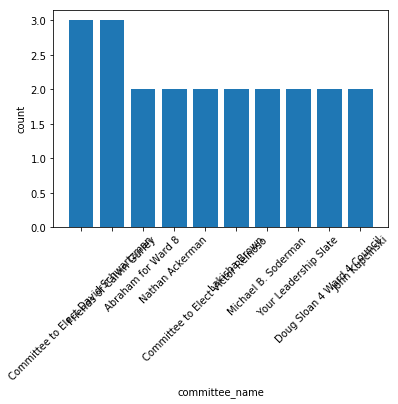

In [5]:
_.bar()

The result above tells us that the differen between contribution which comittees gain is small. Most committees get 2 records of contribution.

In [4]:
%matplotlib inline

In [6]:
%%sql
SELECT election_year, COUNT(*)
FROM campaign
GROUP BY election_year
ORDER BY COUNT DESC
LIMIT 10;

10 rows affected.


election_year,count
2016,502
2014,138
2012,84
2006,84
2002,71
2015,68
2010,66
2004,60
2008,55
2007,49


<Container object of 10 artists>

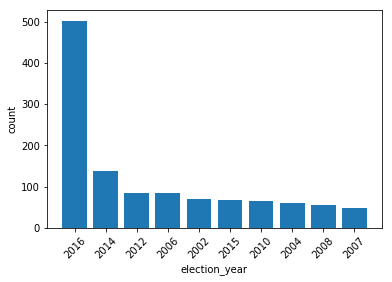

In [7]:
_.bar()

It is very interesting that there are 502 records of contribution in 2016, the highest one. It is almost 3 times bigger than the second one.

In [8]:
%%sql
SELECT type, COUNT(*)
FROM contributor
GROUP BY type
ORDER BY COUNT DESC
LIMIT 10;

10 rows affected.


type,count
Individual,121685
Corporation,20459
Limited Liability Company,751
Organization,327
Candidate,264
Other,192
None,129
Committee,77
Corporate Sponsored PAC,66
Labor,65


<Container object of 10 artists>

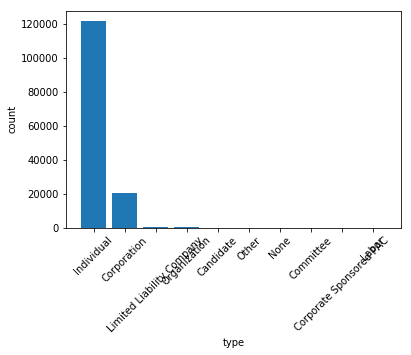

In [9]:
_.bar()

The data show us that individual contribution accounts for the biggest propotion and is 5 times bigger than the corpooration type.

In [17]:
%%sql
SELECT contributor.type, SUM(contribution_facts.amount)
FROM contributor,contribution_facts
WHERE contributor.contributor_key = contribution_facts.contributor_key
GROUP BY contributor.type
ORDER BY SUM DESC
LIMIT 10;

10 rows affected.


type,sum
Individual,40773943.75
Corporation,33034416.73
PCC,1651744.07
Candidate,1628244.17
Organization,699724.40
Other,584448.14
Limited Liability Company,527383.45
Committee,482842.83
None,456211.53
Labor,421375.84


<Container object of 10 artists>

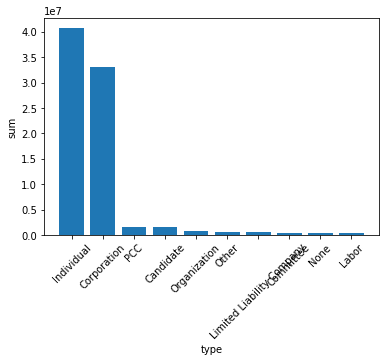

In [18]:
_.bar()

As expected, the amount from individual is the highest but the amount from Corporation is also huge. We can conclude that though the number of contribution from corporation is almost 5 times lower than the one from individual, the amount of each contribution is high so that the difference between them is smaller. Both of them are many times bigger than the amount from other types.